**Оглавление**<a id='toc0_'></a>    
- [Линейные модели](#toc1_)    
- [Линейная регрессия](#toc2_)    
  - [Постановка задачи](#toc2_1_)    
    - [Введение](#toc2_1_1_)    
    - [Функция потерь](#toc2_1_2_)    
    - [Минимизация функции потерь.](#toc2_1_3_)    
  - [Реализация в коде](#toc2_2_)    
    - [Импорт библиотек, описание констант и функций](#toc2_2_1_)    
    - [Реализация аналитического решения](#toc2_2_2_)    
  - [Проблема аналитического решения](#toc2_3_)    
    - [Градиентный спуск](#toc2_3_1_)    
    - [Реализация градиентного спуска](#toc2_3_2_)    
  - [SGD](#toc2_4_)    
  - [Bias–variance tradeoff](#toc2_5_)    
    - [Постановка проблемы](#toc2_5_1_)    
    - [Bias–variance decomposition](#toc2_5_2_)    
    - [Влияние на выбор модели](#toc2_5_3_)    
    - [Одно из решений](#toc2_5_4_)    
  - [Регуляризация](#toc2_6_)    
    - [Постановка проблемы через переобучение модели](#toc2_6_1_)    
    - [Постановка проблемы через мультиколлинеарность признаков](#toc2_6_2_)    
    - [Решение](#toc2_6_3_)    
      - [l1 LASSO регуляризация](#toc2_6_3_1_)    
      - [l2 Ridge регуляризация](#toc2_6_3_2_)    
    - [Дополнительные заметки про регуляризацию.](#toc2_6_4_)    
  - [Масштабирование данных](#toc2_7_)    
    - [Мотивация для масштабирования](#toc2_7_1_)    
    - [Min-Max масштабирование](#toc2_7_2_)    
    - [Стандартизация](#toc2_7_3_)    
    - [Выбор метода масштабирования данных](#toc2_7_4_)    
- [Логистическая регрессия](#toc3_)    
  - [Отличия от регрессии](#toc3_1_)    
  - [Постановка задачи](#toc3_2_)    
    - [Функция потерь](#toc3_2_1_)    
    - [Минимизация функции потерь](#toc3_2_2_)    
  - [Реализация в коде](#toc3_3_)    
    - [Импорт библиотек, описание констант и функций](#toc3_3_1_)    
    - [Реализация логистической регрессии с градиентным спуском и Ridge регуляризацией](#toc3_3_2_)    
- [Приложение](#toc4_)    
  - ["Распремление" поверхности весов из-за мультиколлинеарности признаков](#toc4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Линейные модели](#toc0_)

Представьте, что у вас есть множество объектов $X$, а вы хотели бы каждому объекту сопоставить какое-то значение. Числа, которым мы хотим сопоставить объекты из нашего множества называют таргетами (от английского target). Тогда задачу можно сформулировать как поиск отображения из множества объектов $X$ в множество возможных таргетов. Возможных отображений может быть много, но мы можем упростить себе задачу и договориться, что хотим искать решение только в каком-то заранее заданном параметризированном семействе функций. Весь этот ноутбук будет посвящен самому простому такому семейству — линейным функциям вида: $$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b $$

Подобные функции могут решать задачи регрессии и классификации. Начнём с решения задачи регресии.

# <a id='toc2_'></a>[Линейная регрессия](#toc0_)

## <a id='toc2_1_'></a>[Постановка задачи](#toc0_)

### <a id='toc2_1_1_'></a>[Введение](#toc0_)

Предположим, что между признаками объекта и целевой переменной существует линейная зависимость:
$$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b, $$ где $у$ --- целевая переменная (что мы хотим предсказать), $x_i$ --- признак объекта $х$, $w_i$ --- вес $i$-го признака, $b$ --- bias (смещение, свободный член)

Для удобства опустим свободный член $b$, заменив его добавлением к $x$ фиктивного признака равного 1. В этом случае формула примет упрощенный вид:
$$y = \langle w, x \rangle$$
где $\langle \cdot, \cdot \rangle$ - скалярное произведение векторов $w, x \in \mathbb{R}^n$

В матричной форме, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ y = Xw, $$
где $y$ - столлбец размера $n \times 1$, $X$ - матрица признаков размера $n \times m$, $w$ - вектор весов размера $m \times 1$

**Цель решения задачи линейной регрессии** - нахождение такой матрицы весов $w$, которая позволит наиболее точно приблизить $Xw$ к $y$. Для этого вводится **функция потерь** или **loss function**.

### <a id='toc2_1_2_'></a>[Функция потерь](#toc0_)

Функция потерь оценивает, насколько сильно расходится вектор реальных значений $y$ и вектор предсказаний $y_{pred}$. Так как в нашей задаче вектора живут в одном пространстве, то в качестве функции потерь можно выбрать расстояние между векторами или **L2-норму** разницы векторов (Евклидово расстояние):

$$
\begin{aligned}
L(y_{pred}, y) &= ||y_{pred} - y||_2
\end{aligned}
$$

Однако такая функция ошибки не учитывает размер выборок, поэтому модифицируем её множителем $1/n$, возведём в квадрат и получим **среднеквадратическое отклонение** или **MSE**:


$$
\begin{aligned}
L(y_{pred}, y) &= \frac{1}{n}||y_{pred} - y||^2_2
\end{aligned}
$$

Особенность MSE в том, что она является *функционалом* - получает на вход функцию, а на выходе выдаёт число, которое мы хотим **минимизировать**. Такая постановка функции потерь аналогична [**методу наименьших квадратов**](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2), что в условиях [теоремы Гаусса-Маркова](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%93%D0%B0%D1%83%D1%81%D1%81%D0%B0_%E2%80%94_%D0%9C%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%B0) является оптимальным подходом. Так же стоит отметить, что минимизация среднеквадратичной ошибки это то же самое, что и *максимизация правдоподобия данных*.

Определив функцию потерь, теперь нужно понять, как её минимизировать.

### <a id='toc2_1_3_'></a>[Минимизация функции потерь.](#toc0_)

[Выведем аналитическое решение минимизации функции потерь](https://en.wikipedia.org/wiki/Linear_regression). Минимум фунцкии находится в точке, где градиент этой функции относительно искомой переменной обращается в ноль. Сначала раскроем функцию потерь:

$$
\begin{aligned}
&L(y_{pred}, y) = \frac{1}{n} ||y_{pred} - y||^2_2 = \\ 
&= \frac{1}{n}||Xw - y||^2_2 = \\
&= \frac{1}{n}(Xw - y)^T(Xw - y) = \\
&= \frac{1}{n}( w^T X^TXw - y^TXw - w^T X^Ty  + Y^Ty) =  \\ 
&=\frac{1}{n}(w^TX^TXw - 2y^TXw + Y^Ty),
\end{aligned}
$$
используя следующие свойства:
$$
w^TB^TA = A^TBw
$$
$$
||x||^2_2 = (\sqrt{\langle x, x\rangle})^2 = x^Tx
$$
$$
(AB)^T = B^T A^T
$$

Оптимальное решение относительно $w$ находится в точке, в которой градиент равен нулю. Получим его, используя [свойства получения производных матриц](https://en.wikipedia.org/wiki/Matrix_calculus#Identities), подробнее можно [почитать здесь](https://habr.com/ru/articles/479398/):

$$
\begin{aligned}
\frac{\partial{L}}{\partial{w}} = \frac{\partial{}}{\partial{w}} \frac{1}{n}(w^TX^TXw - 2y^TXw + y^Ty) = \frac{2}{n}(X^TXw - X^Ty) 
\end{aligned}
$$

Или в краткой форме

$$
\begin{aligned}
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}X^T(y_{pred} - y) \,\, \in \mathbb{R}^{m \times 1}
\end{aligned}
$$

Приравняем его к нулю и выразим $w$:

$$
\frac{2}{n}(X^TXw - X^Ty) = 0
$$
$$
X^TXw = X^Ty
$$
$$
w = (X^TX)^{-1} X^Ty
$$

Мы вывели аналитическое решение задачи линейной регрессии. Реализуем и проверим это решение, но сначала импортируем библиотеки, опишем константы и функции.

## <a id='toc2_2_'></a>[Реализация в коде](#toc0_)

### <a id='toc2_2_1_'></a>[Импорт библиотек, описание констант и функций](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
RANDOM_STATE = 1337

np.random.seed(RANDOM_STATE)

In [3]:
def linear_expression(x, a=1, b=1):
    return a * x + b

In [4]:
def linear_data(X_range, a, b, objects_num=100):
    
    X = np.linspace(X_range[0], X_range[1], objects_num)
    y_true = linear_expression(X, a, b)
    y = y_true + np.random.randn(objects_num) * 5
    X = X.reshape(-1, 1)

    return X, y, y_true

In [5]:
def multicollinear_data(n=100):
    np.random.seed(RANDOM_STATE) # нужно зафиксировать в ячейке, для повторяемости результатов
    
    X1 = np.random.randint(0, 100, n)
    X2 = X1 + np.random.normal(0, 0.001, n)
    X3 = np.random.randint(0, 100, n)
    
    y = 3*X1 + 2*X2 + X3 + np.random.randint(0, 10, n)
    X = np.column_stack((X1, X2, X3))

    return X, y

In [6]:
def results_metrics_weights(model, X, y, y_pred):

    print('Веса модели:', [x.round(4) for x in model.get_weights()])
    print('MSE: ', mean_squared_error(y, y_pred).round(4))

In [7]:
def predictions_graph(ax, model, X, y_real, y_pred, func_real):
    ax.scatter(X, y_real, c='orange', label='real data')
    
    ax.plot(X, func_real, label='real', c='g')
    ax.plot(X, y_pred, label='predicted', c='r')
    
    ax.set_ylabel('Целевая переменная')
    ax.set_xlabel('Признак')
    ax.set_title('График заданной и полученной зависимостей')
    ax.grid(alpha=0.2)
    ax.legend()

In [8]:
def plot_predictions(model, X, y_real, y_pred, func_real):
    fig, ax = plt.subplots(figsize=(7, 5))
    predictions_graph(ax, model, X, y_real, y_pred, func_real)
    plt.show() 

In [9]:
def losses_graph(ax, model):
    losses = model.get_losses()
    ax.plot(losses, color='blue', label='_nolegend_')
    
    last_loss = losses[-1]

    ax.plot([], [], ' ', label=f'Last loss: {last_loss:.2f}')
    
    ax.set_title('Gradient descent learning')
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax.grid(alpha=0.6)
    ax.legend()

In [10]:
def plot_losses(model):
    fig, ax = plt.subplots(figsize=(7, 5))
    losses_graph(ax, model)
    plt.show() 

In [11]:
def equipotentials_graph(ax, X, y, weights_history, optimal_weights, C, range_x, range_y):
    X_ = np.hstack((X, np.ones((X.shape[0], 1))))
    
    points = []
    for w1 in np.arange(range_x[0], range_x[1], 0.5):
        for w2 in np.arange(range_y[0], range_y[1], 0.5):
            w = np.array([w1, w2])
            y_pred = X_ @ w
            loss = mean_squared_error(y, y_pred)

            if C:
                regularization_term = (1 / C) * np.sum(np.square(w[:-1]))
                loss += regularization_term
                
            points.append((w1, w2, loss))
    
    w1_vals = np.array([point[0] for point in points])
    w2_vals = np.array([point[1] for point in points])
    loss_vals = np.array([point[2] for point in points])
    
    contour = ax.tricontourf(w1_vals, w2_vals, loss_vals, levels=30, cmap='viridis_r')
    plt.colorbar(contour, ax=ax, label='Total Loss')

    if C:
        title = 'Контуры Loss в плоскости w1-w2 с регуляризацией'
    else:
        title = 'Контуры Loss в плоскости w1-w2'
    
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(title)
    
    ax.plot(weights_history[:, 0], weights_history[:, 1], c='red', alpha=1, linewidth=1, label='История весов')
    ax.scatter(weights_history[:, 0], weights_history[:, 1], c='black', alpha=1, s=3)
    ax.scatter(optimal_weights[0], optimal_weights[1], c='blue', label='Опт веса', s=100, edgecolor='black')
    
    ax.legend(loc='upper left')

In [12]:
def plot_equipotentials(X, y, weights_history, optimal_weights, C=None, range_x=(-2, 6), range_y=(-2, 9)):
    fig, ax = plt.subplots(figsize=(7, 5))
    equipotentials_graph(ax, X, y, weights_history, optimal_weights, C, range_x, range_y)
    plt.show() 

In [13]:
def plot_reg_results(
    model,
    X,
    y_real,
    y_pred,
    func_real,
    weights_history,
    optimal_weights=[3, 7],
    C=None,
    range_x=(-2, 6),
    range_y=(-2, 9),
):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    predictions_graph(axes[0], model, X, y_real, y_pred, func_real)
    losses_graph(axes[1], model)
    equipotentials_graph(
        axes[2], X, y_real, weights_history, optimal_weights, C, range_x, range_y
    )

    plt.tight_layout()
    plt.show()

In [14]:
def plot_weights_history(weights_history):
    plt.figure(figsize=(6,4))
    plt.plot(weights_history[:,0])
    plt.plot(weights_history[:,1])
    plt.grid()
    plt.show()

### <a id='toc2_2_2_'></a>[Реализация аналитического решения](#toc0_)

[Создадим класс `MyLinearRegression`](https://stepik.org/course/196127/syllabus), в котором опишем методы обучения, предсказания и получения матрицы весов.

In [15]:
class MyLinearRegression:

    def __init__(self, **kwargs):
        pass
        self.w = None
        
    def fit(self, X, y):
        n, _ = X.shape
        
        X_train = np.hstack((X, np.ones((n, 1))))
        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self

    def predict(self, X):
        n, _ = X.shape
        X_train = np.hstack((X, np.ones((n, 1))))
        y_pred = X_train @ self.w
        
        return y_pred

    def get_weights(self):
        return self.w

Данные получим из функции `linear_data`. Признак создадим равномерно распределенным, а целевую переменную создадим на основе признака, домножив его на $3$ и добавив $7$. Это и будут наши коэффиценты, эти же числа мы и хотим получить в матрице $w$.

In [16]:
X, y, y_true = linear_data((-5, 5), a=3, b=7, objects_num=100)

In [17]:
model_analytic = MyLinearRegression()
model_analytic.fit(X, y);
pred_analytic = model_analytic.predict(X)

Построим графики объектов, реальной зависимости и предсказанной.

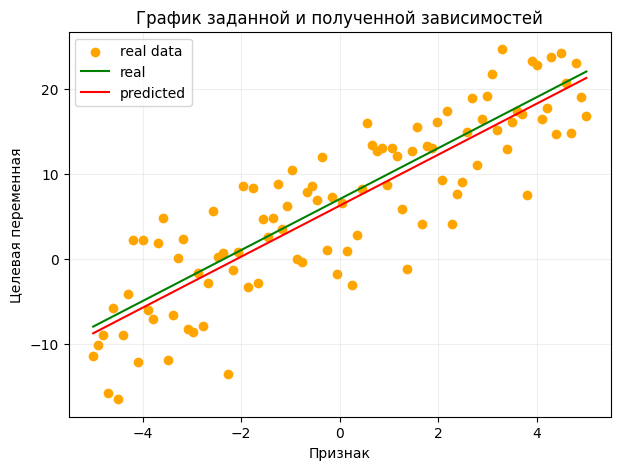

In [18]:
plot_predictions(model_analytic, X, y, pred_analytic, y_true)

In [19]:
results_metrics_weights(model_analytic, X, y, pred_analytic)

Веса модели: [3.0029, 6.2269]
MSE:  25.6026


Мы получили довольно точное приближение.

## <a id='toc2_3_'></a>[Проблема аналитического решения](#toc0_)

Основная проблема в обращении матрицы — это то, [что вычислительно обращать большие матрицы дело сложное](https://stats.stackexchange.com/questions/278755/why-use-gradient-descent-for-linear-regression-when-a-closed-form-math-solution), а мы бы хотели работать с датасетами, в которых у нас могут быть миллионы точек. Вычислительная сложность аналитического решения — $O(D^2N+D^3)$, где, $N$ – длина выборки, $D$ – число признаков у одного объекта.

Кроме того, обратная матрица $(X^TX)^{-1}$ может быть [вырождена или плохо обусловлена](https://alexanderdyakonov.wordpress.com/2019/10/31/%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F/) в случае, когда столбцы $X$ имеют некоторую степень корреляции, что приведёт к тому, что матрица коэффицентов $w$ станет чувствительной к шуму и случайным ошибкам, и, как следствие, коэффициенты станут неадэкватными. 

В связи с этим применяют метод **градиентного спуска**.

### <a id='toc2_3_1_'></a>[Градиентный спуск](#toc0_)

Градиентный спуск это численный метод нахождения локального минимума или максимума функции с помощью движения вдоль градиента. Напомним, что в нашей задаче мы хотим минимизировать функцию потерь. Этапы градиентного спуска:

1. Расчет $\displaystyle\frac{\partial{L}}{\partial{w}}$ -- градиента ошибки (значение целевой функции, то есть лосса $L(y_{pred}, y_{true})$) от значения параметров модели (весов $w$). В нашем случае:
$$
\begin{aligned}
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}X^T(Xw - Y)
\end{aligned}
$$
2. Изменение весов $w$ в сторону антиградиента с некоторым коэффициентом $\alpha$ (он же learning rate):
$$w = w - \alpha\frac{\partial{L}}{\partial{w}}$$
3. Повторение п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют), либо пока не достигнуто максимальное число иттераций.

Общие замечания:
* Поскольку задача выпуклая, выбор начальной точки влияет на скорость сходимости, но не настолько сильно, чтобы на практике нельзя было стартовать всегда из нуля или из любой другой приятной вам точки;
* Число обусловленности матрицы существенно влияет на скорость сходимости градиентного спуска: чем более вытянуты эллипсоиды уровня функции потерь, тем хуже;
* Темп обучения тоже сильно влияет на поведение градиентного спуска; вообще говоря, он является гиперпараметром алгоритма, и его, возможно, придётся подбирать отдельно. Другими гиперпараметрами являются максимальное число итераций и/или порог tolerance.
 
Вычислительная сложность градиентного спуска – $O(NDS)$, где, как и выше, $N$ – длина выборки, $D$ – число признаков у одного объекта, $S$ - число иттераций.

### <a id='toc2_3_2_'></a>[Реализация градиентного спуска](#toc0_)

Класс `MyGradientLinearRegression` будет аналогичен предыдущему, с добавлением приватных методов `_calc_gradient` для вычисления градиента и `_loss` для вычисления ошибки (с аргументом $w$, который нам пригодится в будущем). Так же добавим метод `get_losses` и `get_weights` для получения ошибок и весов.
Зафиксруем `random_state` при инициализации, так как мы не планируем работать с этим параметром.

In [20]:
class MyGradientLinearRegression():
    def __init__(self, lr=0.01, max_iter=100):
        self.lr = lr
        self.max_iter = max_iter
        self.random_state = RANDOM_STATE
        self.w = None

    def fit(self, X, y):
        np.random.seed(self.random_state)

        self.losses = []
        self.weights = []
        n, m = X.shape
        self.w = np.random.randn(m + 1)
        X_train = np.hstack((X, np.ones((n, 1))))

        for _ in range(self.max_iter):
            
            self.weights.append(np.copy(self.w))
            y_pred = self.predict(X)
            grad = self._calc_gradient(X_train, y, y_pred)
            self.w -= self.lr * grad
            self.losses.append(self._loss(y, y_pred, self.w))
            
        return self

    def _calc_gradient(self, X, y, y_pred):
        n, _ = X.shape
        grad = (2/n) * np.dot(X.T, (y_pred-y))
        
        return grad

    def _loss(self, y, y_pred, w):
        return mean_squared_error(y, y_pred)

    def predict(self, X):
        n, _ = X.shape
        X_train = np.hstack((X, np.ones((n, 1))))
        y_pred = X_train @ self.w
        
        return y_pred

    def get_losses(self):
        return self.losses

    def get_weights(self, history=False):
        if history: return np.array(self.weights)
        else: return self.w

In [21]:
model_gradient = MyGradientLinearRegression(lr=0.02)
model_gradient.fit(X, y);
pred_gradient = model_gradient.predict(X)

In [22]:
results_metrics_weights(model_gradient, X, y, pred_gradient)

Веса модели: [3.0029, 6.1136]
MSE:  25.6154


In [23]:
weights_history_gradient = model_gradient.get_weights(history=True)

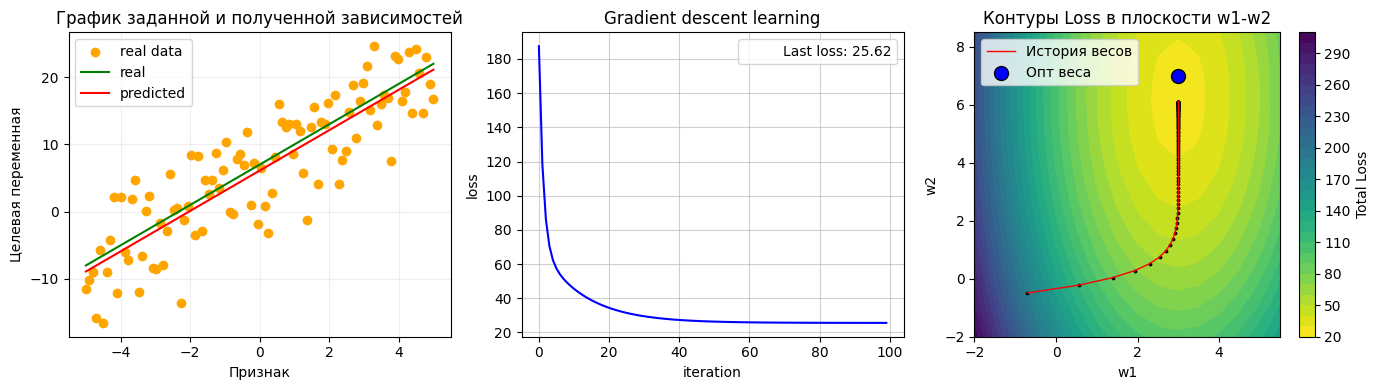

In [24]:
plot_reg_results(model_gradient, X, y, pred_gradient, y_true, weights_history_gradient)

Тоже отличный результат. Однако на каждой иттерации нам нужно загружать в память и обработатывать сразу всю выборку. Возникает идея заменить градиент его оценкой на подвыборке.

## <a id='toc2_4_'></a>[SGD](#toc0_)

<img src="https://yastatic.net/s3/ml-handbook/admin/1_7_4b8031112e.png" width="800" height="400">

Стохастический градиентный спуск - стохастическая аппроксимация метода градиентного спуска на случайной подвыборке. Для реализации `SGD` будем случано выбирать `n_sample` элементов из тренировочной выборки. Однако наиболее оптимальный подход - перемешиване выборки изначально, и далее получение индексов подвыборки линейным проходом.

Сложность по времени – $O(NDE)$, где - $E$ - количество эпох в случае с линейным проходом по индексам.

Для демонстрации выкрутим `SGD` на максимум - сделаем размер выборки 5. Сходимость снизится, поэтому увеличим количество иттераций `max_iter` и `lr`, чтобы прийти в минимум.

In [25]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        n, _ = X.shape
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        grad = (2/n) * np.dot(X[inds].T, (y_pred[inds] - y[inds]))
        return grad

In [26]:
model_SGD = MySGDLinearRegression(n_sample=5, lr=0.1, max_iter=200)
model_SGD.fit(X, y);
pred_SGD = model_SGD.predict(X)

In [27]:
results_metrics_weights(model_SGD, X, y, pred_SGD)

Веса модели: [2.8447, 5.3096]
MSE:  26.6567


In [28]:
weights_history_SGD = model_SGD.get_weights(history=True)

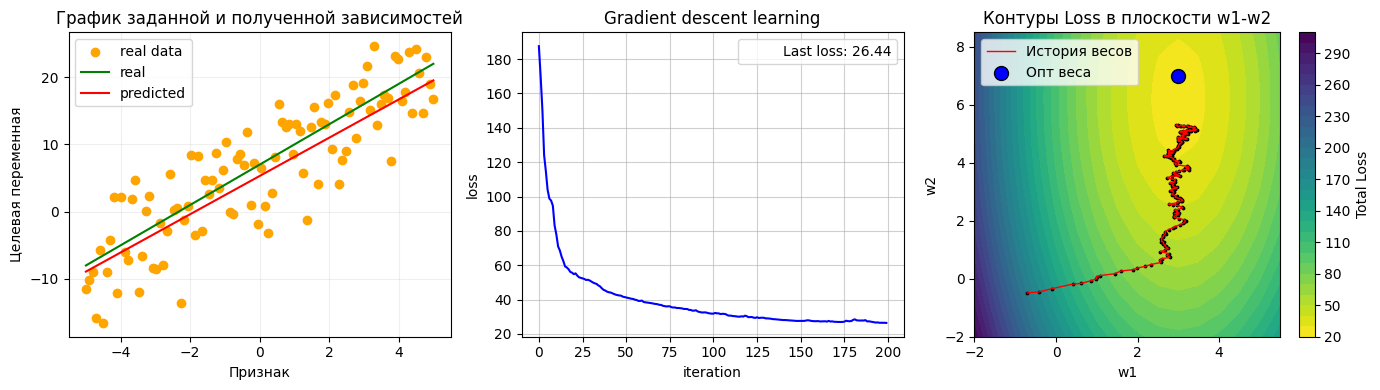

In [29]:
plot_reg_results(model_SGD, X, y, pred_SGD, y_true, weights_history_SGD)

Видно, что сходимость `SGD` хуже и зависит от гиперпараметра `n_sample`. Таким образом `SGD` позволяет выбирать, что важнее - затраты в производительности или сходимость решения.

Далее рассмотрим несколько проблем, свойственных линейным (и не только) моделям.

## <a id='toc2_5_'></a>[Bias–variance tradeoff](#toc0_)

### <a id='toc2_5_1_'></a>[Постановка проблемы](#toc0_)

Первая проблема алгоритмов машинного обучения, которую можно сформулировать уже на этом этапе: [дилемма смещения-дисперсии](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). Продемонстрируем её.

Предположим, что у нас есть тренировочный набор данных $x_1, ..., x_n$ и реальные значения $y_i$, связанные с каждой точкой $x_i$. Мы предпологаем, что данные порождены функцией $f(x)$ такой, что $y = f(x) + \epsilon$, где $\epsilon$ - шум, обладающий свойствами $E[\epsilon]=0$ и $Var(\epsilon)=\sigma^2$. 

Мы хотим найти функцию $\hat{f}(x, D)$, которая как можно точнее приближает истинную  функцию $f(x)$ с помощью некоторого алгоритма обучения на основе обучающего набора данных (выборки) $D=\{(x_1, y_1)...(x_n, y_n)\}$. Мы определяем "как можно точнее" измерением среднеквадратичной ошибки между $y$ и $\hat{f}(x, D)$. Мы хотим, чтобы эта ошибка была минимальной и для $x_1, ..., x_n$, и для *объектов вне нашей тренировочной выборки*. Конечно мы не можем рассчитывать на нулевое значение ошибки, потому что $y$ содержит шум, поэтому нам придётся принять *неустранимую ошибку* в любой функции, с которой будем работать. Однако есть и другие факторы, которые будут составлять итоговую ошибку. Покажем их.

### <a id='toc2_5_2_'></a>[Bias–variance decomposition](#toc0_)

Оказывается, что какую бы функцию $\hat{f}$ мы ни выбрали, мы можем разложить её ожидаемую ошибку на непросмотренном экземпляре данных $x$ следующим образом:

$$
\begin{aligned}
Err = E[(y - \hat{f})^2] = E[y^2] - 2E[y\hat{f}] + E[\hat{f}^2]
\end{aligned}
$$

Разложим каждое слагаемое:

$$
\begin{aligned}
E[y^2] = E[(f + \epsilon)^2] = E[f^2] + 2E[f\epsilon] + E[\epsilon^2] = f^2 + 2f*0 + \sigma^2 = f^2 + \sigma^2
\end{aligned}
$$

$E[f^2] = f^2$ исходя из детерминированности $f$,  
$E[\epsilon] = 0$ из определения шума,  
$E[\epsilon^2] = \sigma^2$, так как $Var(x) = E[x^2] - E[x]^2 = E[x^2] = \sigma^2$ при $E[x] = 0$.

$$
\begin{aligned}
E[y\hat{f}] = E[(f + \epsilon)\hat{f}] = E[f\hat{f}] + E[\epsilon\hat{f}] = E[f\hat{f}] + E[\epsilon]E[\hat{f}] = fE[\hat{f}]
\end{aligned}
$$

$$
\begin{aligned}
E[\hat{f}^2] = Var(\hat{f}) + E[\hat{f}]^2
\end{aligned}
$$

Соберём все вместе

$$
\begin{aligned}
&Err = f^2 + \sigma^2 - 2fE[\hat{f}] + Var(\hat{f}) + E[\hat{f}]^2 = \\
&= (f - E[\hat{f}])^2 + Var(\hat{f}) + \sigma^2 = \\
&= (E[f] - E[\hat{f}])^2 + Var(\hat{f}) + \sigma^2 = \\
&= Bias[\hat{f}]^2 + Var(\hat{f}) + \sigma^2
\end{aligned}
$$

Три члена представляют:

* квадрат *смещения* метода обучения, который можно рассматривать как ошибку, вызванную упрощением предположений, принятых в методе. Например, когда применяется аппроксимация нелинейной функции $f$ при использовании метода обучения для линейных, будет появляться ошибка в $\hat{f}$ как результат такого допущения;
* *дисперсия* метода обучения, или, интуитивно, как далеко от среднего значения метод $\hat{f}$ будет давать предсказания;
* *неустранимая ошибка* $\sigma^2$.

Поскольку все три величины неотрицательны, они формируют нижнюю границу ожидаемой ошибки на неизвестных данных.

Для упрощения вывода было принято допущение, которое сейчас стоит озвучить. На самом деле функция $\hat{f}$ это функция от двух переменных: невиденные до этого (тестовые) признаки $x$ и тренировочные данные $D$, так как они влияют на вид этой функции. То есть $Bias$ показывает, насколько смещается мат ожидание фунцкции при изменении тренировочных данных от мат ожидания реальной функции, а $Var$ показывает разброс предасказаний при изменении тренировочных данных. $Bias$ - функция от $\hat{f}$ и $f$, $Var$ - функция от $f$.

### <a id='toc2_5_3_'></a>[Влияние на выбор модели](#toc0_)

[Wiki](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%BB%D0%B5%D0%BC%D0%BC%D0%B0_%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D1%8F-%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D0%B8):  
Выбираемая модель должна, с одной стороны, точно уловить все закономерности в обучающих данных, а с другой стороны — обобщить закономерности на неизвестные данные. К сожалению, обычно это невозможно сделать одновременно. Методы обучения с высокой дисперсией могут хорошо представлять тренировочный набор, но имеют риск быть переобученными для данных с шумом или непрезентативных данных. В отличие от них, алгоритмы с низкой дисперсией обычно дают более простые модели, не склонно к переобучению, но может оказаться недообученным, что приводит к пропуску важных свойств.

Модели с малым смещением обычно более сложны (например, в них регрессионные многочлены имеют более высокий порядок), что позволяет им представлять тренировочное множество более точно. Однако они могут иметь большую компоненту шуматренировочного набора, что делает предсказание менее точным вопреки добавленной сложности. Для контраста, модели с высоким смещением относительно более просты (имеют многочлены меньшего порядка или даже линейные), но могут давать низкую дисперсию предсказаний, если применяются вне тренировочного набора.

[Yandex](https://education.yandex.ru/handbook/ml/article/bias-variance-decomposition):  
Смещение показывает, насколько хорошо с помощью данного алгоритма можно приблизить истинную зависимость
, а разброс характеризует чувствительность алгоритма к изменениям в обучающей выборке. Например, деревья маленькой глубины будут в большинстве случаев иметь высокое смещение и низкий разброс предсказаний, так как они не могут слишком хорошо запомнить обучающую выборку. А глубокие деревья, наоборот, могут безошибочно выучить обучающую выборку и потому будут иметь высокий разброс в зависимости от выборки, однако их предсказания в среднем будут точнее. 

Соотношение сложности модели со смещением и дисперсией [выражается следующим графиком](https://scott.fortmann-roe.com/docs/BiasVariance.html):

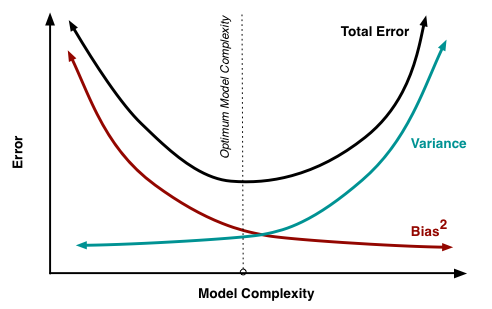

Оптимальная точка

$$
\begin{aligned}
\frac{\partial{Bias}}{\partial{Complexity}} = - \frac{\partial{Variance}}{\partial{Complexity}} 
\end{aligned}
$$

### <a id='toc2_5_4_'></a>[Одно из решений](#toc0_)

Бэггинг (Bootstrap Aggregating) и другие методы ресэмплинга могут быть использованы для снижения дисперсии в прогнозах модели. В бэггинге, создается множество репликатов исходного набора данных путем случайного выбора с возвращением. Каждый производный набор данных затем используется для построения новой модели, и эти модели собираются в ансамбль. Для получания прогноза все модели в ансамбле опрашиваются, и их результаты усредняются.

Одним из мощных алгоритмов моделирования, который хорошо использует бэггинг, являются Случайные Леса (Random Forests). Случайные Леса работают путем обучения множества деревьев решений, каждое из которых основано на различном ресэмплинге исходных данных обучения. В Random Forests смещение полной модели эквивалентно смещению одиночного дерева решений (которое само по себе имеет высокую дисперсию). Создавая много таких деревьев, в сущности "лес", а затем усредняя ихможно добиться значительного снижения дисперсии а по сравнению с одиночным деревом. На практике единственным ограничением на размер леса является время вычислений, поскольку бесконечное количество деревьев могло бы быть обучено без увеличения смещения и с постоянным (асимптотически убывающим) уменьшением дисперсии.

Мы разобрались с дилеммой смещения-дисперсии. Теперь рассмотрим, что такое "регуляризация".

## <a id='toc2_6_'></a>[Регуляризация](#toc0_)

Для начала определение: регуляризцаия, это ограничение значений весов модели, что приводит к упрощению модели и улучшению производительности на незнакомых наборах данных. Причины для применения регуляризации обычно имеют две интерпретации: большие веса являются следствием переобучения модели и большие веса являются следствием мультиколлинеарности признаков. Рассмотрим оба подхода.

### <a id='toc2_6_1_'></a>[Постановка проблемы через переобучение модели](#toc0_)

Если мы сможем ограничить гибкость модели, это может помочь улучшить её производительность на новых, не виденных данных. В общем, любое изменение метода обучения, направленное на улучшение производительности на незнакомых наборах данных, называется регуляризацией. Нам нужна регуляризация, чтобы ввести смещение в модель и уменьшить дисперсию. Это можно достичь путем модификации функции потерь с добавлением штрафного члена, который эффективно уменьшает оценки коэффициентов. Поэтому такие методы в рамках регрессии также называются методами «сжатия» или «штрафной регрессией».

Что такое переобученная модель? Это модель, которая слишком хорошо подстроилась (в случае с линейными моделями - подобрала коэффициенты $w$) под тренировочную выборку. Что значит "слишком хорошо"? Как было выяснено в предыдущей главе целевая переменная $y$ всегда имеет некоторую шумовую составляющую. И модель может подстроиться под этот шум или под выбросы в данных, показав замечательную метрику на тренировочной выборке, но при этом значительно снизив качество на тестовой. Пример на картинках ниже.

<div style="display: flex; justify-content: space-around;">

<div style="text-align: center;">
    <img src="https://www.dmitrymakarov.ru/wp-content/uploads/2021/07/under-over-fitting-1200x418.jpg" alt="Вторая картинка" style="width: 750px; height: auto;">
    <p></p>
</div>

<div style="text-align: center;">
    <img src="https://www.dmitrymakarov.ru/wp-content/uploads/2022/12/test_overfit.jpg" alt="Первая картинка" style="width: 500px; height: auto;">
    <p></p>
</div>


</div>

Для борьбы с переобученем модель нужно упростить. Что значит "успростить"? Ограничить значения весов $w$, что уменьшить вклад или вовсе занулить некоторые веса. Почему это работает именно так [это хороший отдельный большой вопрос](https://stats.stackexchange.com/questions/188092/why-do-smaller-weights-result-in-simpler-models-in-regularization). В терминах предыдущей главы мы хотим ввести смещение в модель и уменьшить дисперсию. Как это сделать? Модифицировать функцию потерь с добавлением штрафного члена, который эффективно уменьшает оценки коэффициентов, что мы покажем после того, как поставим проблему через мультиколлинеарность признаков.

### <a id='toc2_6_2_'></a>[Постановка проблемы через мультиколлинеарность признаков](#toc0_)

Пусть в выборке есть линейно зависимые признаки. Тогда существует вектор $v$, что для любого объекта $x$ выполнено $\langle v, x \rangle$ = 0. Допустим, мы нашли оптимальный вектор весов $w$ для линейного классификатора. Но тогда классификаторы с векторами весов $w+αv$ будут давать точно такие же ответы на всех объектах, поскольку $\langle w + αv, x \rangle$ = $\langle w , x \rangle$ + $α\langle v , x \rangle$ = $\langle w , x \rangle$. Проиллюстрируем.

В матрице $ \begin{bmatrix} 1 & 1 & 2 \\\ 0 & 2 & 4 \\\ -5 & 3 & 6 \\\ 3 & 1 & 2 \end{bmatrix}$ второй и третий столбцы линейнозависимы с коэффициентом 2. Тогда вектор $v$ $ \begin{bmatrix} 0\\\ -2*a \\\ a\end{bmatrix}$ будет давать результат $ \begin{bmatrix} 1*0 & 1*(-2a) & 2*a \\\ 0*0 & 2*(-2a) & 4*a \\\ -5*0 & 3*(-2a) & 6*a \\\ 3*0 & 1*(-2a) & 2*a \end{bmatrix}$ = $ \begin{bmatrix} 0 \\\ 0 \\\ 0 \\\ 0 \end{bmatrix}$

Так же можно сказать, что $L(w)$ "распремляется", и её минимум повышает размерность на количество коллинеарностей. Для двумерной поверхности весов минимум станет не точкой, а прямой (смотри в приложении). Всё это значит, что матрица весов не только не единственная, но ещё и может быть со сколько угодно большими весами. Такие решения не очень хороши, поскольку классификатор будет чувствителен к крайне маленьким изменениям в признаках объекта, что, кстати, тоже является симптомом переобучения модели. Малые погрешности признаков сильно возрастают при предсказании ответа, а в градиентном спуске накапливается погрешность из-за операций со слишком большими числами.

При этом определитель матрицы $X^TX$ будет равен нулю (легко проверить на приведённой выше матрице), то есть матрица будет вырожденной. Однако на практике чистая линейная зависимость между признаками встречается редко, но мы можем наблюдать так называемую *мультиколлинеарность* — когда два или несколько признаков сильно коррелированы, в матрице $X$. Например, в задаче прогнозирования цены квартиры по ее параметрам "почти" линейная зависимость будет у признаков "площадь с учетом балкона" и "площадь без учета балкона". Формально для таких данных матрица $X^T X$ будет обратима, но из-за мультиколлинеарности у матрицы $X^T X$ некоторые собственные значения будут близки к нулю, а в обратной матрице $\left(X^T X\right)^{-1}$ появятся экстремально большие собственные значения, т.к. собственные значения обратной матрицы – это $\frac{1}{\lambda_i}$. Например если к третьему столбцу указанной выше матрицы добавить $0.1$, чем нарушить линейную зависимость столбцов, но при этом сохранить мультиколлинеарность, то собственные числа для $X^TX$ равны $(23.737, 0.00019, 89.102)$ (причём здесь собственные значения рекомендуется подумать самостоятельно). Итогом такого шатания собственных значений станет нестабильная оценка параметров модели, т.е. добавление нового наблюдения в набор тренировочных данных приведёт к совершенно другому решению.

Создадим данные, у которых `X1` и `X2` будут мультиколлинеарны.

In [30]:
X, y = multicollinear_data()

In [31]:
model_analytic_reg = MyLinearRegression()
model_analytic_reg.fit(X, y);
pred_analytic_reg = model_analytic_reg.predict(X)

In [32]:
results_metrics_weights(model_analytic_reg, X, y, pred_analytic_reg)

Веса модели: [100.4929, -95.4717, 0.9918, 3.7641]
MSE:  6.4959


In [33]:
model_gradient_reg = MyGradientLinearRegression(lr=0.0001, max_iter=100)
model_gradient_reg.fit(X, y);
pred_gradient_reg = model_gradient_reg.predict(X)

In [34]:
results_metrics_weights(model_gradient_reg, X, y, pred_gradient_reg)

Веса модели: [2.4276, 2.6405, 1.035, -1.7002]
MSE:  11.1429


Видно, что коэффициенты аналитического решения получаются неадэкватными, однако градиентное решение показывает более приемлемые коэффициенты. При этом для него пришлось подбирать *learning_rate*, из-за того, что градиенты в ходе обучения принимали бесконечные значения. Это происходит из-за того, что вообще говоря веса и градиент функции потерь (и тем более сами значения функции потерь, которые являются квадратичной функцией от весов и признаков) - величины скорее разного масштаба, которые как раз и согласуются с помощью *learning_rate*. Получается, если признаки будут иметь разные масштабы, то каждому из них может потребоваться свой *learning_rate* для гладкого перемещения градиента по поверхности функции ошибки, что не очень удобно. Для решения этой проблемы используют **масштабирование признаков**, но об этом чуть позже. А пока вернёмся к некорректным весам моделей.

Теперь мы можем сформулировать решение этой проблемы.

### <a id='toc2_6_3_'></a>[Решение](#toc0_)

Мы хотим штрафовать модели за большие веса. Для этого введём в уравнение функции ошибки дополнительный *регуляризационный член*, который будет увеличивать ошибку пропорционально увеличению весов по модулю с некоторым *коэффициентом регуляризации*:

$$
\begin{aligned}
L(w) = \frac{1}{n} ||Xw - Y||^2_2 + \lambda||w||^k_k,
\end{aligned}
$$
где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

Коэффициент $\lambda$ является гиперпараметром модели и достаточно сильно влияет на качество итогового решения. Его подбирают по логарифмической шкале (скажем, от 1e-2 до 1e+2), используя для сравнения моделей с разными значениями $\lambda$ дополнительную валидационную выборку. Отдельно надо договориться о том, что вес $w0$, соответствующий отступу от начала координат (то есть признаку из всех единичек), мы регуляризовать не будем, потому что это не имеет смысла: если даже все значения $w0$ равномерно велики, это не должно портить качество обучения.

При регуляризации у нас появляется, по сути, две функции ошибки: основная (синяя), наказывающая за отклонение истинных значений от прогнозных, и дополнительная (оранжевая), наказывающая за отклонение коэффициентов от нуля. [Их сумму и будет пытаться минимизировать алгоритм](https://explained.ai/regularization/index.html).

<img src="https://www.dmitrymakarov.ru/wp-content/uploads/2022/12/L2_constraint.jpg" width="500" height="350">

Различают следующие виды регуляризации:
- $l_1$-регуляризацию (LASSO, least absolute shrinkage and selection operator), которая учитывает $l_1$ норму матрицы весов $||w||_1$

- $l_2$-регуляризацию (Ridge), которая учитывает $l_2$ норму матрицы весов $||w||^2_2$

- Elastic net - комбинация двух предыдущих (учитываются обе нормы весов)

Рассмотрим подробно первые два вида.

#### <a id='toc2_6_3_1_'></a>[l1 LASSO регуляризация](#toc0_)

[$l_1$ норма матрицы весов $||w||_1$](https://medium.com/@datasciencejourney100_83560/difference-between-l1-manhattan-and-l2-euclidean-distance-c70b5da25fe0) раскрывается как сумма модулей весов и функция потерь приобритает вид:

$$
\begin{aligned}
L1 = \frac{1}{n} ||Xw - Y||^2_2  + \lambda\sum_{i=1}^{m}|w_i|
\end{aligned}
$$

Обратите внимание на $i=1$ в сумме: мы не будем регуляризировать свободный член $w0$, ведь если даже все значения $y$ равномерно велики, это не должно портить качество обучения. 

[Градиент:](https://math.stackexchange.com/questions/391001/taking-derivative-of-l-0-norm-l-1-norm-l-2-norm)

$$
\frac{\partial{L1}}{\partial{w}} = \frac{2}{n}X^T(Xw - Y) + \lambda sign(w)
$$

В связи с наличием $sign(w)$ мы не можем выразить $w$ и получить аналитическое решение.

#### <a id='toc2_6_3_2_'></a>[l2 Ridge регуляризация](#toc0_)

[$l_2$ норма матрицы весов $||w||^2_2$](https://medium.com/@datasciencejourney100_83560/difference-between-l1-manhattan-and-l2-euclidean-distance-c70b5da25fe0) раскрывается как сумма квадратов весов и функция потерь приобритает вид:

$$
L2 = \frac{1}{n} ||Xw - Y||^2_2  + \lambda\sum_{i=1}^{m}w_i^2
$$

[Градиент:](https://math.stackexchange.com/questions/883016/gradient-of-2-norm-squared)

$$
\frac{\partial{L2}}{\partial{w}} = \frac{2}{n}X^T(Xw - y) + 2 \lambda w
$$

Для аналитического решения прировняем градиент:

$$
\frac{2}{n}X^T(Xw - y) + 2 \lambda w = 0
$$

$$
X^TXw + n \lambda w = X^Ty
$$

Вынесем $w$ за скобки, при этом для сохранения размерностей в скобках $n\lambda$ умножим на единичную матрицу $E$, а само слагаемое $n\lambda$ представим как $\lambda$, так как в обоих случаях это просто константа.  Затем оставим в правой части только $w$:

$$
w = (X^TX + \lambda E)^{-1}X^Ty
$$

Однако в ML чаще встречается коэффициент регуляризации $C=1/\lambda$, который прямопропорционален сложности (complexity) модели, поэтому при реализации класса будем использовать его.

Отметим, что за этой формулой стоит и понятная численная интуиция: раз матрица $X^TX$ близка к вырожденной, то обращать её сродни самоубийству. Мы лучше слегка исказим её добавкой $\lambda E$, которая увеличит все собственные значения на $\lambda$, отодвинув их от нуля. Да, аналитическое решение перестаёт быть «точным», но за счёт снижения численных проблем мы получим более качественное решение, чем при использовании «точной» формулы. Так же имеется мнение, что название "регуляризация" произшло именно от этого действия - приведения $X^TX$ к регулярному виду.

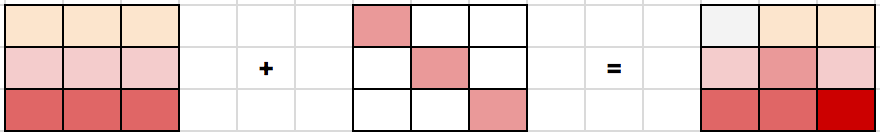

В ходе преобразований добавилась единичная матрица $E$, от которой и произошло название "Ridge" - гребневая.  
Теперь имплиментируем в коде градиентное решение (аналитическое не будем), наследовав класс `MyGradientRidge` от класса `MyGradientLinearRegression` и добавив регуляризацию Ridge к оптимизационному алгоритму. При этом напомним, что не будем регуляризовать последний (отвечающий за смещение) коэффициент.

In [35]:
class MyGradientRidge(MyGradientLinearRegression):
    def __init__(self, C=1.0, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.C = C

    def _calc_gradient(self, X, y, y_pred):
        n, _ = X.shape
        lambdaE = (2 / self.C) * np.eye(self.w.shape[0])
        lambdaE[-1, -1] = 0
        grad = (2/n) * np.dot(X.T, (y_pred-y)) + np.dot(lambdaE, self.w)
        return grad

    def _loss(self, y, y_pred, w):
        return mean_squared_error(y, y_pred) + (1 / self.C) * np.sum(np.square(w[:-1]))

In [36]:
X, y, y_true = linear_data((-5, 5), a=3, b=7, objects_num=100)

In [37]:
C_100000 = 100000

model_GR_1 = MyGradientRidge(max_iter=200, C=C_100000)
model_GR_1.fit(X, y);
pred_GR_1 = model_GR_1.predict(X)

In [38]:
weights_history_GR_1 = model_GR_1.get_weights(history=True)

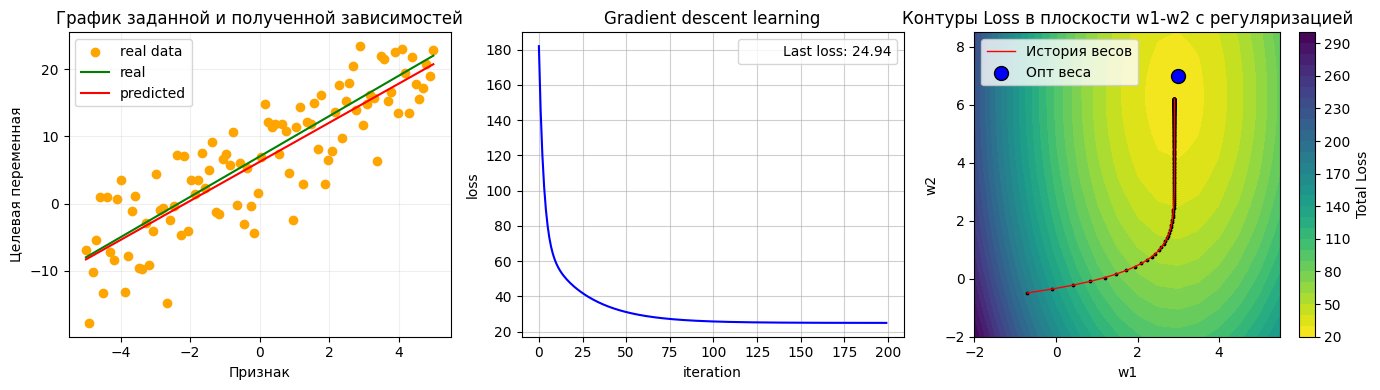

In [39]:
plot_reg_results(model_GR_1, X, y, pred_GR_1, y_true, weights_history_GR_1, C=C_100000)

При больших значениях $C$ регуляризация практически не видна, модель не имеет ограничений.

In [40]:
C_01 = 0.1

model_GR_2 = MyGradientRidge(max_iter=300, C=C_01)
model_GR_2.fit(X, y);
pred_GR_2 = model_GR_2.predict(X)

In [41]:
weights_history_GR_2 = model_GR_2.get_weights(history=True)

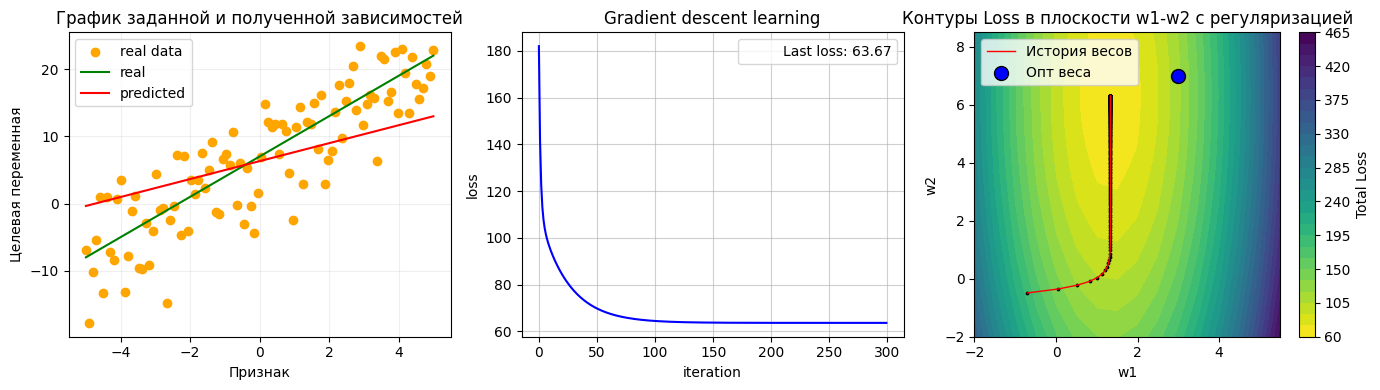

In [42]:
plot_reg_results(model_GR_2, X, y, pred_GR_2, y_true, weights_history_GR_2, C=C_01)

Видно, как оптимум весов регулязированного решения сместился ближе к нулю по весу $w1$, который мы регуляризовали.
Так же при малых значениях $C$ видно, что значения функции потерь сходятся к бо'льшему значению из-за штрафа. И модель получается не такой точной на тренировочной выборке, но должна показать лучшую эффективность на тестовой, здесь показан неудачный пример.

### <a id='toc2_6_4_'></a>[Дополнительные заметки про регуляризацию.](#toc0_)

$l_2$-регуляризация работает прекрасно и используется в большинстве случаев, но есть одна полезная особенность $l_1$-регуляризации: её применение приводит к тому, что у признаков, которые не оказывают большого влияния на ответ, вес в результате оптимизации получается равным $0$. Это позволяет удобным образом удалять признаки, слабо влияющие на таргет. Кроме того, это даёт возможность автоматически избавляться от признаков, которые участвуют в соотношениях приближённой линейной зависимости, соответственно, спасает от проблем, связанных с мультиколлинеарностью, о которых мы писали выше.

Линии уровня $l_1$-нормы – это $N$-мерные октаэдры. Точки их касания с линиями уровня лосса, скорее всего, лежат на грани размерности, меньшей $N-1$, то есть как раз в области, где часть координат равна нулю:

<img src="https://yastatic.net/s3/ml-handbook/admin/1_9_c157936d62.png" width="800" height="400">

Модели, в которых некоторые веса равны нулю, [называют *разреженными*](https://kstu.kg/fileadmin/user_upload/lecture4_machine_learning_orozobekova_a.k..pdf), поскольку прогноз в них зависит лишь от части признаков. Потребность в таких моделях можно возникнуть по многим причинам. Несколько примеров:
1. Может быть заведомо известно, что релевантными являются не все признаки. Очевидно, что признаки, которые не имеют отношения к задаче, надо исключать из данных, то есть производить отбор признаков. Есть много способов решения этой задачи, и $l_1$-регуляризация — один из них.
2. К модели могут выдвигаться ограничения по скорости построения предсказаний. В этом случае модель должна зависеть от небольшого количества наиболее важных признаков, и тут тоже оказывается полезной $l_1$-регуляризация.
3. В обучающей выборке объектов может быть существенно меньше, чем признаков (так называемая «проблема N ≪ p»). Поскольку параметров линейной модели при этом тоже больше, чем объектов, задача обучения оказывается некорректной — решений много, и сложно выбрать из них то, которое обладает хорошей обобщающей способностью. Решить эту проблему можно путём внедрения в процесс обучения априорного знания о том, что целевая переменная зависит от небольшого количества признаков. Такая модификация как раз может быть сделана с помощью $l_1$-регуляризатора.

Регуляризированное решение уменьшает дисперсию, но становится смещенным, т.к. минимизируется также и норма вектора параметров, что заставляет решение сдвигаться в сторону нуля. На рисунке ниже на пересечении белых пунктирных линий находится МНК-решение. Голубыми точками обозначены различные решения гребневой регрессии. Видно, что при увеличении параметра регуляризации $\lambda$ решение сдвигается в сторону нуля.

<img src="https://habrastorage.org/r/w1560/files/2f7/484/d31/2f7484d31b98416296ad3bab430854ee.png" width="500" height="350">

[Вот ещё просто интересный вопрос на stackexchange о связи регуляризации и one-hot encoding](https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding/329281#329281) и [отличные заметки про регуляризацию](https://explained.ai/regularization/index.html)

Последний подход для работы с линейными моделями, который не относится к реализации линейных моделей, но который стоит описать в этой тетрадке (тем более было обещано) - **масштабирование данных**.

## <a id='toc2_7_'></a>[Масштабирование данных](#toc0_)

### <a id='toc2_7_1_'></a>[Мотивация для масштабирования](#toc0_)

Мы уже затрагивали эту тему ранее и отмечали, что *learning_rate* нужен для согласования порядка весов и градиента функции потерь. При этом если наши признаки имеют разные масштабы, то и веса, и градиент для них подбираются с разными масштабами, что приводит к неравномерному перемещению по поверхности функции потерь, а правильнее сказать, что сама поверхность функции потерь вытягивается из-за разного масштаба признаков -> весов и перемещение градиента по ней не оптимально (что можно было бы исправить разным *learning_rate* для каждого признака, но это уже перебор, а если признаков 1000?). Это видно даже на наших графиках. Отобразим ещё раз, сконцентрировавшись на весах.

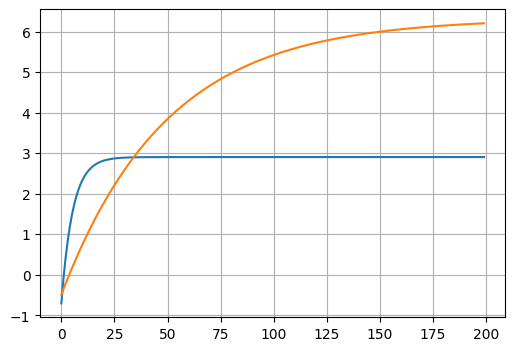

In [43]:
plot_weights_history(weights_history_GR_1)

При этом если отличия признаки отличаются значительно (например в $10^4$ раз), то мы можем вовсе не прийти к минимуму функции потерь, либо это займёт больше времени. Поэтому было бы неплохо, чтобы признаки имели одинаковый масштаб, чтобы и их веса были близки. Это приведёт ещё и к улучшению **интерпретируемости** модели - для признаков одного масштаба верно, что чем больше вес признака, тем более он важен для получения предсказания, однако смысл самих коэффициентыов не будет так очевиден. Рассмотрим на примере выдуманной связи роста и возраста с размером ноги. Если мы масштабируем рост и возраст и вместо 180см и 25 лет получаем 0.9 и 0.7, то соотношение к целевой переменной вовсе не обязательно сохранится. Условно первая модель могла иметь веса $180*0.2 + 25*0.4 = 46$, то модель на масштабированных признаках может выглядеть $0.9*45 + 0.7*8=46$. В первом случае можно интерпретировать связь каждого признака и целевой переменной, зато во втором видно, что первый признак значительно важнее.

Отдельно стоит отметить, что масштабирование (какое именно, рассмотрим позже) признаков необходимо при применении регуляризации ([ссылка 1](https://stats.stackexchange.com/questions/19523/need-for-centering-and-standardizing-data-in-regression) и [ссылка 2](https://stats.stackexchange.com/questions/201909/when-to-normalize-data-in-regression)). Логика такая же, как и с *learning_rate*: для адэкватного штрафа необходимо, чтобы веса имели один масштаб.

Особенно важно масштабирование признаков для алгоритмов [SVM](https://stats.stackexchange.com/questions/65094/why-scaling-is-important-for-the-linear-svm-classification) и [KNN](https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn), которые будут рассмотрены в будущем. Эти алгоритмы основаны на вычислении расстояний между точками данных. Если объекты имеют разные масштабы, в расчетных расстояниях могут доминировать объекты с более крупными масштабами, что приведет к неточным результатам. Масштабирование объектов может решить эту проблему и обеспечить расчет расстояний на основе фактических отношений между точками данных.

Что бы понять, как масштабировать данные, рассмотрим два самых часто используемых метода: **Min-Max** и **стандартизация**. Но сначала импортируем библиотеки и опишем функции.

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [45]:
def scaler_example(scaler):
    data_train = [[-2, 2], [-0.5, 6], [0, 10], [1, 18]]
    data_test = [[-4 , 20], [1, 5]]
    
    data_train_scaled = scaler.fit_transform(data_train)
    data_test_scaled = scaler.transform(data_test)

    print('data_train_scaled')
    print(data_train_scaled)
    print()
    print('data_test_scaled')
    print(data_test_scaled)

In [46]:
def plot_distribution(data, mean, std, title, ax):
    sns.histplot(data, bins=50, ax=ax, kde=True, legend=False)
    ax.set_title(title)

    ax.legend([
        f'Mean 1: {mean[0]:.2f}',
        f'Std Dev 1: {std[0]:.2f}',
        f'Mean 2: {mean[1]:.2f}',
        f'Std Dev 2: {std[1]:.2f}'
    ], handlelength=0)

In [47]:
def plot_boxplot(data, title, ax):
    sns.boxplot(data=data, ax=ax, orient='h')
    ax.set_title(title)

In [48]:
def data_distribution(scaler):
    original_data = np.random.exponential(size=1000).reshape(-1, 1) - 3
    additional_feature = np.random.normal(loc=2.0, scale=0.2, size=(1000, 1))
    combined_original = np.hstack((original_data, additional_feature))
    
    scaled_data = scaler.fit_transform(combined_original)

    original_mean = np.mean(combined_original, axis=0)
    original_std = np.std(combined_original, axis=0)
    scaled_mean = np.mean(scaled_data, axis=0)
    scaled_std = np.std(scaled_data, axis=0)

    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    plot_distribution(combined_original, original_mean, original_std, "Оригинальные данные", ax1)

    ax2 = fig.add_subplot(gs[0, 1])
    plot_distribution(scaled_data, scaled_mean, scaled_std, "Масштабированные данные", ax2)

    ax3 = fig.add_subplot(gs[1, 0])
    plot_boxplot(combined_original, "Боксплот оригинальных данных", ax3)

    ax4 = fig.add_subplot(gs[1, 1])
    plot_boxplot(scaled_data, "Боксплот масштабированных данных", ax4)
    
    plt.tight_layout()
    plt.show()

### <a id='toc2_7_2_'></a>[Min-Max масштабирование](#toc0_)

[Min-max масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) (далее MinMaxScaler) используется для приведения данных в указанных диапазон, обычно $[0,1]$ по формуле:

$$
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

В процессе масштабирования MinMaxScaler, вычитая минимальное значение из каждой точки данных и деля результат на диапазон (максимальное значение минус минимальное значение), значения признака преобразуются в диапазон $[0,1]$. Этот процесс гарантирует, что минимальное значение становится $0$, а максимальное значение — $1$, при этом сохраняются относительные отношения между остальными значениями.

In [49]:
scaler_min_max = MinMaxScaler()

scaler_example(scaler_min_max)

data_train_scaled
[[0.         0.        ]
 [0.5        0.25      ]
 [0.66666667 0.5       ]
 [1.         1.        ]]

data_test_scaled
[[-0.66666667  1.125     ]
 [ 1.          0.1875    ]]


Обратите внимание, скейлер сначала обучается на тренировочной выборке и только потом применяется к тестовой. Это связано с тем, что тестовый набор играет роль новых, не виденных ранее данных, поэтому он не должен быть доступен на этапе обучения. Использование любой информации из тестового набора до или во время обучения может привести к потенциальному искажению оценки производительности. При нормализации тестового набора необходимо применять параметры нормализации, полученные ранее из обучающего набора, в том виде, в каком они есть. Другими словами произойдёт *утечка*. Не следует пересчитывать их на тестовом наборе, поскольку это будет не согласовано с моделью и приведет к неверным предсказаниям. Более подробно [можно почитать здесь](https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data).

Из результатов видно, что если признаки в тестовой выборке имеют значения больше, чем в тренировочной, то после масштабирования они будут вне диапазона $[0,1]$. Это свойственно и StandardScaler. Так же MinMaxScalerx чувствителен к выбросам, так как одно значение, сильно большее, чем все остальные, значительно сократит значения всей выборки.

Посмотрим, как меняется распределение данных при применении MinMaxScaler для данных, полученных из экспоненциального и нормального распределений.

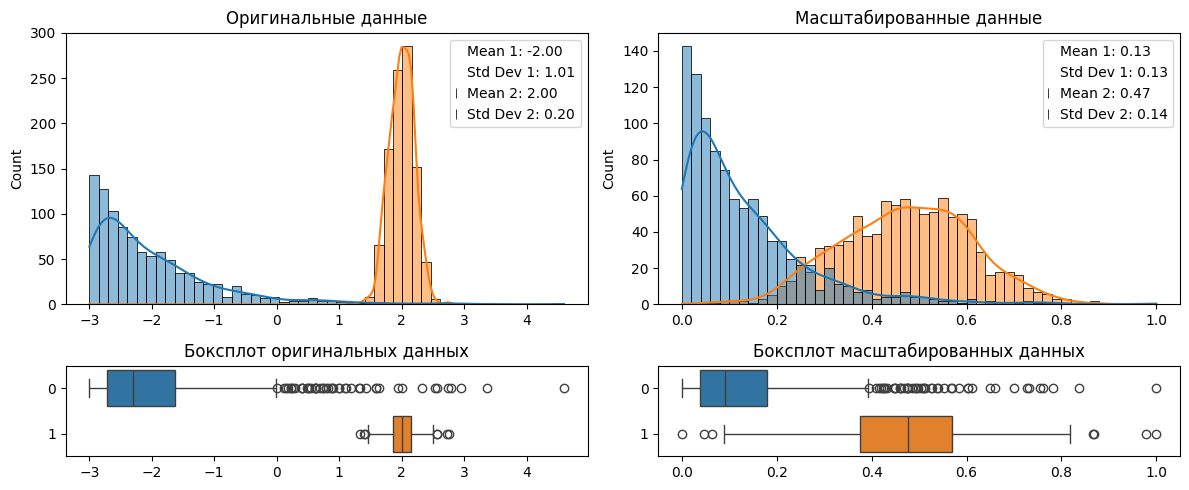

In [50]:
data_distribution(scaler_min_max)

Обе характеристики были масштабированы так, чтобы находиться в диапазоне от 0 до 1, а межквартильные разности (IQR) стали более сопоставимыми по размеру, что иллюстрирует, что характеристики теперь находятся на схожем масштабе.

Теперь рассмотрим второй способ масштабирования данных: **стандартизация**.

### <a id='toc2_7_3_'></a>[Стандартизация](#toc0_)

[Стандартизация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) (далее StandardScaler) приводит признаки к распределению [со средним 0 и стандартным отклонением 1](https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler). Для этого каждое значение в данных преобразуется следующим образом:.

$$
Z = \frac{x-\mu}{\sigma},
$$
где  
$\mu$ - среднее изначального набора данных,  
$\sigma$ - стандартное отклонение изначального набора данных

Такое преобразование также называется **Z-score normalization**.

In [51]:
scaler_std = StandardScaler()

scaler_example(scaler_std)

data_train_scaled
[[-1.5011107  -1.18321596]
 [-0.11547005 -0.50709255]
 [ 0.34641016  0.16903085]
 [ 1.27017059  1.52127766]]

data_test_scaled
[[-3.34863156  1.85933936]
 [ 1.27017059 -0.6761234 ]]


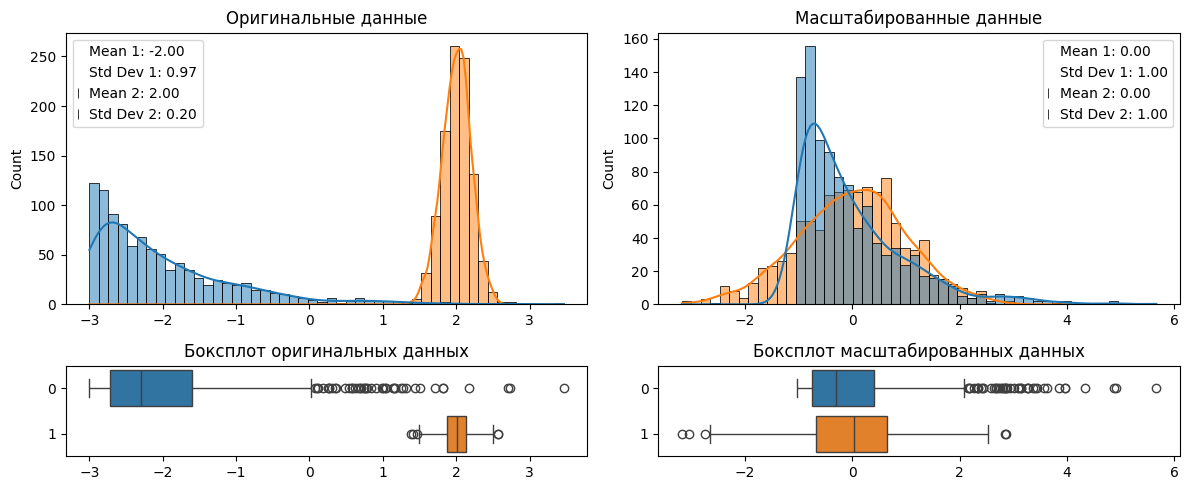

In [52]:
data_distribution(scaler_std)

Обе характеристики после стандартизации имеют нулевое среднее и стандартные отклонения равные $1$, при этом медианы так же близки. Межквартильные разности (IQR) тоже стали сопоставимы.

### <a id='toc2_7_4_'></a>[Выбор метода масштабирования данных](#toc0_)

MinMaxScaler лучше применять, когда данные имеют ограниченный и заранее известный масштаб, например, в обработке изображений значения пикселей обычно находятся в диапазоне от $0$ до $255$. Масштабирование этих значений с использованием MinMaxScaler обеспечивает то, что значения находятся в фиксированном диапазоне и вносят одинаковый вклад в анализ. [Аналогично, при работе с негауссовскими распределениями](https://vitalflux.com/minmaxscaler-standardscaler-python-examples/#:~:text=MinMaxScaler%20is%20useful%20when%20the,contributes%20equally%20to%20the%20analysis.), такими как распределение по степенному закону, можно использовать MinMaxScaler, чтобы гарантировать, что диапазон значений масштабируется между $0$ и $1$.

Так же MinMaxScaler можно применять к данным для обучения алгоритмов, которые не делают предположений о распределении данных, таких как деревьев решений и случайных лесов. Эти алгоритмы не зависят от масштаба признаков, так как они основываются на делении пространства на основе значений признаков, поэтому можно использовать разные методы масштабирования, но нормализация в диапазоне $[0, 1]$ может позволить лучше интерпретировать результаты.

StandardScaler лучше применять к данным, на которых будут обучаться линейные алгоритмы, kNN, k-means, SVM и PCA. Первые используют градиентный спуск, а StandardScaler позволяет привести распределения данных около $0$, что улучшит сходимость, при этом у признаков сохранится разница в масштабах. Плюс линейные модели предполагают, что данные распределены нормально, с чем помогает StandardScaler. Если обобщать kNN, k-means, SVM и PCA, то они используют расстояния, [которые так же лучше масштабировать StandardScaler](https://stackoverflow.com/questions/32108179/linear-regression-normalization-vs-standardization), чтобы сохранить информацию о размахе признаков. При этом StandardScaler лучше подходит для данных, распределённых нормально и более устойчив к выбросам.

В данной тетрадке мы не применяем методы масштабирования данных, потому что изначально подбираем признаки схожих масштабов, плюс некоторые визуализации получаются нагляднее. Теперь можно приступать ко вторму разделу: решению задачи классификации. Это можно делать с помощью **логистической регрессии**.

# <a id='toc3_'></a>[Логистическая регрессия](#toc0_)

Логистическая регрессия является частным случаем *линейного классификатора*. Основная идея линейного классификатора заключается в том, что признаковое пространство может быть разделено гиперплоскостью на два полупространства (для задачи бинарной классификации), в каждом из которых прогнозируется одно из двух значений целевого класса.

## <a id='toc3_1_'></a>[Отличия от регрессии](#toc0_)

Мы можем попробовать предсказывать числа $-1$ и $1$, минимизируя для этого, например, MSE с последующим взятием знака, но ничего хорошего не получится. Во-первых, регрессия почти не штрафует за ошибки на объектах, которые лежат близко к *разделяющей плоскости*, но не с той стороны. Во вторых, ошибкой будет считаться предсказание, например, $5$ вместо $1$, хотя нам-то на самом деле не важно, какой у числа модуль, лишь бы знак был правильным. Если визуализировать такое решение, то проблемы тоже вполне заметны:

<img src="https://yastatic.net/s3/ml-handbook/admin/1_11_0fe41ca811.png" width="500" height="300">

Так же при получении удачной линии регрессии, появление новых данных сместит эту границу, и, как следствие, ничего не добавит, а только ухудшит точность модели:

<img src="https://www.dmitrymakarov.ru/wp-content/uploads/2022/04/new-observation-case.png" width="500" height="250">

## <a id='toc3_2_'></a>[Постановка задачи](#toc0_)

In [53]:
def plot_logloss():
    def L(y):
        return - y * np.log(p) - (1 - y) * np.log(1 - p)
    
    p = np.linspace(0.01, 0.99, 100)
    
    logloss_y0 = L(0)
    logloss_y1 = L(1)
    
    plt.figure(figsize=(7,4))
    plt.plot(p, logloss_y0, label='-log(p) | y=0', color='blue')
    plt.plot(p, logloss_y1, label='-log(1-p) | y=1', color='orange')
    
    plt.title('Логистическая Потеря (Log Loss) для y=0 и y=1')
    plt.xlabel('Предсказанная вероятность p')
    plt.ylabel('Логистическая потеря')
    plt.ylim(0, 5)
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.legend()
    plt.grid()
    plt.show()

In [54]:
def plot_sigmoid():
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    x = np.linspace(-8, 8, 100)
    y = sigmoid(x)
    
    plt.figure(figsize=(7, 4))
    plt.plot(x, y, label='Сигмоида', color='blue')
    plt.title('График функции сигмоида')
    plt.xlabel('x')
    plt.ylabel('σ(x)')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.xlim(-8, 8)
    plt.ylim(-0.1, 1.1)
    plt.grid()
    plt.show()

Итак, в идеале нам хотелось бы пресдказывать не метки классов, а *вероятности принадлежности объектов к классам*. Проблема состоит в том, что вероятность, по определению, величина от 0 до 1, а простого способа обучить линейную модель так, чтобы это ограничение соблюдалось, нет. Из этой ситуации можно выйти так: научить линейную модель правильно предсказывать какой-то объект, связанный с вероятностью, но с диапазоном значений $(-\infty, \infty)$, и преобразовать ответы модели в вероятность. Таким объектом является **logit** или **log odds** – логарифм отношения вероятности положительного события к отрицательному - $log(\frac{p}{1-p})$. То есть модель предсказывает логит, который в дальнейшем будет трансформирован в вероятность принадлежности к классу:

$$
\langle w, x \rangle = log(\frac{p}{1-p})
$$
$$
e^{\langle w, x \rangle} = \frac{p}{1-p}
$$
$$
p = \frac{1}{1+e^{\langle w, x \rangle}}
$$

Функция в правой части называется **сигмоидой**, она выполняет преобразование $R → [0, 1]
$
 и обозначается:

$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

График сигмоиды:

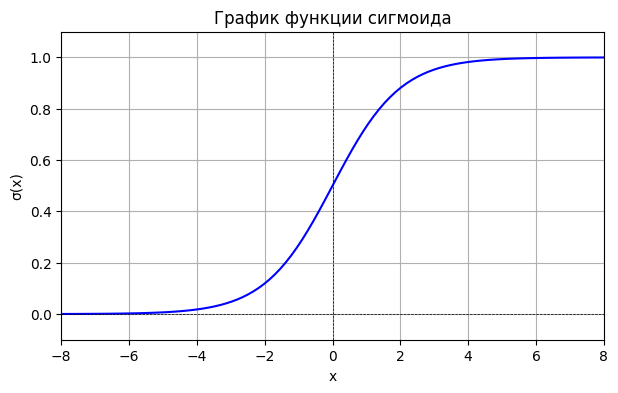

In [55]:
plot_sigmoid()

Таким образом, $p=\sigma({\langle w, x \rangle})$. Как теперь оптимизировать решение? Нужно применить метод *максимума правдоподобия для распределения Бернулли*.

### <a id='toc3_2_1_'></a>[Функция потерь](#toc0_)

Правдоподобие позволяет понять, насколько вероятно получить данные значения таргета $y$ при данных $X$ и весах $w$. Оно имеет вид:

$$
p(y|X, w) = \prod_{i} p(y_i|x_i, w)
$$

и для распределения Бернулли его можно выписать следующим образом:

$$
p(y|X, w) = \prod_{i} p_i^{y_i} (1-p_i)^{1-y_i},
$$

где $p_i$ – это вероятность, посчитанная из ответов модели.

От произведения перейдём к сумме с помощью логарифмирования и подставим формулу для вероятности:

$$
l(w, X, y) = \sum_{i} (y_i log(p_i) + (1-y_i) log (1-p_i)) = \sum_{i} (y_i log(\sigma({\langle w, x \rangle})) + (1-y_i) log (-\sigma({\langle w, x \rangle}))),
$$
так как $\sigma(-z) = 1-\sigma(z)$

В модели логистической регрессии мы не можем использовать MSE. Дело в том, что если мы поместим результат сигмоиды (представляющей собою нелинейную функцию) в MSE, то на выходе получим невыпуклую функцию (non-convex), глобальный минимум которой довольно сложно найти. Вместо MSE мы будем использовать функцию **логистической ошибки**, которую еще называют функцией **бинарной кросс-энтропии** (log loss, binary cross-entropy loss).

Нас интересует $w$, для которого правдоподобие максимально. Чтобы получить **логистическую функцию потерь**, которую мы будем **минимизировать**, умножим его на минус один:

$$
L(w, X, y)  = - \sum_{i} (y_i log(\sigma({\langle w, x \rangle})) + (1-y_i) log (-\sigma({\langle w, x \rangle}))),
$$

Для каждого из классов logloss принимает следующий вид:

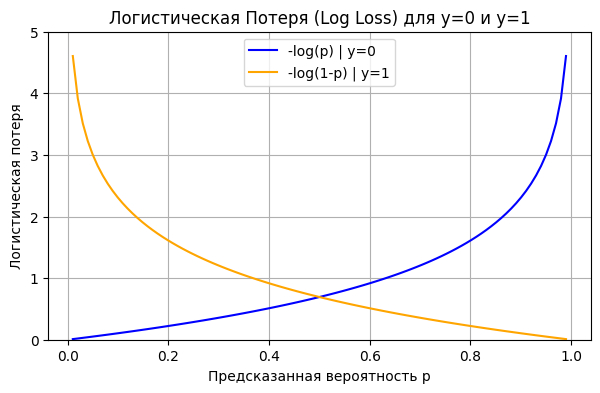

In [56]:
plot_logloss()

Отметим неприятное свойство logloss: если для объекта 1го класса мы предсказываем нулевую вероятность принадлежности к этому классу или, наоборот, для объекта 0го – единичную вероятность принадлежности к классу 1, то ошибка равна бесконечности! Таким образом, грубая ошибка на одном объекте сразу делает алгоритм бесполезным. На практике часто логлосс ограничивают каким-то большим числом (чтобы не связываться с бесконечностями).

Функция потерь определена, теперь посмотрим, как её минимизировать.

### <a id='toc3_2_2_'></a>[Минимизация функции потерь](#toc0_)

В отличие от линейной регрессии, для логистической нет явной формулы решения, поэтому будем использовать градиентный спуск.

Так как
$$
\frac{\partial{log(\sigma(z))}}{\partial{z}} =\sigma(-z) =>  \frac{log(\sigma({\langle w, x_i \rangle})}{\partial{w}} = \sigma(-{\langle w, x_i \rangle})x_i
$$ 
$$
\frac{\partial{L}}{\partial{w}} = - \sum_{i} x_i ( y_i -\sigma({\langle w, x_i \rangle})) = - \sum_{i} x_i ( y_i - p_i)
$$

Или в матричной форме:
$$
\frac{\partial{L}}{\partial{w}} = X^T (p - y)
$$

Перед реализацией в коде стоит отметить, что при очень больших отрицательных или положительных значениях $z$ может возникнуть переполнение памяти. Преодолеть это ограничение и добиться вычислительной устойчивости алгоритма можно с помощью следующего тождества:

$$
\sigma(z) = \frac{1}{1+e^{-z}} = \frac{e^z}{e^{z}+1}
$$

Что интересно, первая часть тождества устойчива при очень больших положительных значениях $z$, при этом вторая стабильна при очень больших отрицательных значениях $z$.

Регуляризация логистической регрессии имеет такой же вид, как и линейной регрессии:

$$
\frac{\partial{L1}}{\partial{w}} = X^T (p - y) + \lambda sign(w)
$$
$$
\frac{\partial{L2}}{\partial{w}} = X^T (p - y) + 2 \lambda w
$$

Теперь у нас есть всё, чтобы реализовать код для логистической регрессии с Ridge регуляризацией.

## <a id='toc3_3_'></a>[Реализация в коде](#toc0_)

### <a id='toc3_3_1_'></a>[Импорт библиотек, описание констант и функций](#toc0_)

In [57]:
from sklearn.datasets import make_blobs

In [58]:
def plot_decision_boundary(ax, clf, X, y):
    colors = ("magenta", "green")
    colored_y = np.zeros(y.size, dtype=str)

    for i, cl in enumerate([0, 1]):
        colored_y[y == cl] = str(colors[i])

    eps = 0.1
    xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]) - eps, np.max(X[:, 0]) + eps, 500),
                         np.linspace(np.min(X[:, 1]) - eps, np.max(X[:, 1]) + eps, 500))

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'), shading='auto')

    Z_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_pred = Z_pred.reshape(xx.shape)

    contour = ax.contour(xx, yy, Z_pred, levels=[0.5], linewidths=2, colors='black')

    ax.scatter(X[:, 0], X[:, 1], c=colored_y)
    ax.set_title('Разделяющая плоскость логистической регрессии')
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')

In [59]:
def plot_equipotentials(X, y, weights_history, range=(-2, 10)):
    fig, ax = plt.subplots(figsize=(7, 5))
    equipotentials_graph(ax, X, y, weights_history, range)
    plt.show() 

In [60]:
def plot_clf_results(model, X, y_real):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_decision_boundary(axes[0], model, X, y_real)
    losses_graph(axes[1], model)
    
    plt.tight_layout()
    plt.show()

### <a id='toc3_3_2_'></a>[Реализация логистической регрессии с градиентным спуском и Ridge регуляризацией](#toc0_)

In [61]:
class MyLogisticRegression():
    def __init__(self, lr=0.01, max_iter=100, C=1.0):
        self.lr = lr
        self.max_iter = max_iter
        self.C = C
        self.random_state = RANDOM_STATE
        self.w = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        self.losses = []
        self.weights = []
        n, m = X.shape
        self.w = np.random.randn(m + 1)
        X_train = np.hstack((X, np.ones((n, 1))))

        for _ in range(self.max_iter):
            self.weights.append(np.copy(self.w))
            p_pred = self.predict_proba(X)
            grad = (2/n) * self._calc_gradient(X_train, y, p_pred)

            self.w -= self.lr * grad
            self.losses.append(self._loss(y, p_pred))

        return self

    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.hstack((X, np.ones((n, 1))))
        return np.array([self._stable_sigmoid(value) for value in self._logit(X_, self.w)])

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self, history=False):
        if history:
            return np.array(self.weights)
        else:
            return self.w

    def get_losses(self):
        return self.losses

    def _calc_gradient(self, X_train, y, p_pred):
        grad = np.dot(X_train.T, (p_pred - y))
        grad += (2 / self.C) * self.w
        return grad

    def _loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        loss = np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
        loss += (1 / (2 * self.C * len(y))) * np.sum(self.w[:-1] ** 2)
        return -loss

    def _logit(self, x, w):
        return np.dot(x, w)

    def _stable_sigmoid(self, z):
        if z >= 0:
            return 1 / (1 + np.exp(-z))
        else:
            return np.exp(z) / (np.exp(z) + 1)

In [62]:
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[2,-0.5]], cluster_std=1, random_state=RANDOM_STATE)

Построим два классификатора с `C=100` и `C=0.003`.

In [63]:
CLF_1 = MyLogisticRegression(max_iter=100, lr=0.1, C=100)

CLF_1.fit(X, y);

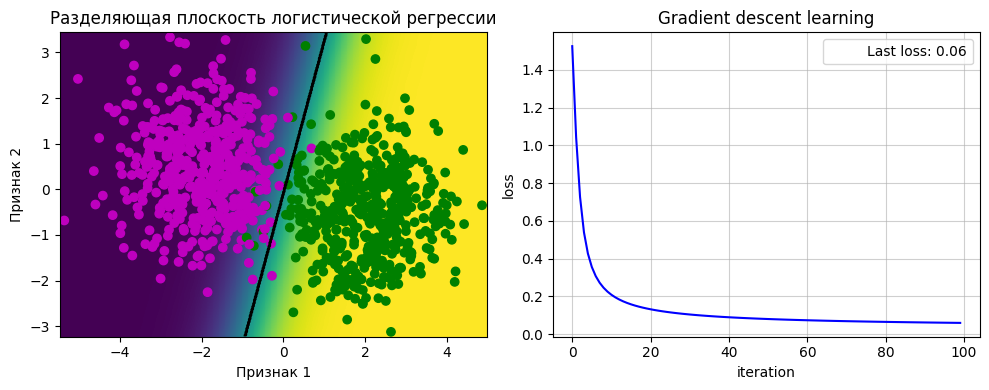

In [64]:
plot_clf_results(CLF_1, X, y)

In [65]:
CLF_2 = MyLogisticRegression(max_iter=100, lr=0.1, C=0.003)

CLF_2.fit(X, y);

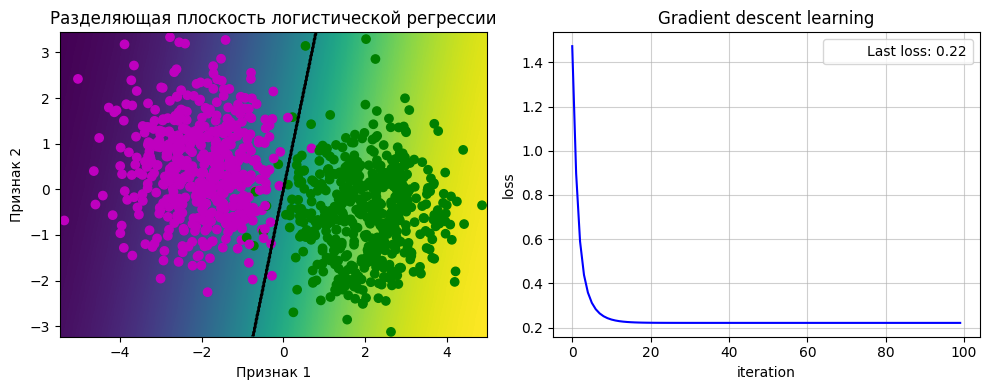

In [66]:
plot_clf_results(CLF_2, X, y)

Два наблюдения:
1. Потери с сильной регуляризацией (низкой сложностью `C=0.003`) больше
2. Граница более размыта, модель предсказывает довольно близкие к $\frac{1}{2}$ вероятности – это значит, что значения ${\langle x, x\rangle}$ близки к нулю, то есть сам вектор $w$ близок к нулевому. Это также свидетельствует о том, что регуляризационный член играет слишком важную роль при оптимизации. Наименьший коэффициент регуляризации у первой модели. Её предсказания достаточно «уверенные» (цвета на графике сочные, то есть вероятности быстро приближаются к $0$ или $1$). Это может свидетельствовать о том, что числа ${\langle x, x\rangle}$ достаточно велики по модулю, то есть $||w||$ достаточно велик.

# <a id='toc4_'></a>[Приложение](#toc0_)

## <a id='toc4_1_'></a>["Распремление" поверхности весов из-за мультиколлинеарности признаков](#toc0_)

In [67]:
from mpl_toolkits.mplot3d import Axes3D

In [68]:
X1 = np.array([1, 2, 3])
X2 = X1

y = X1 + X2
X = np.column_stack((X1, X2))

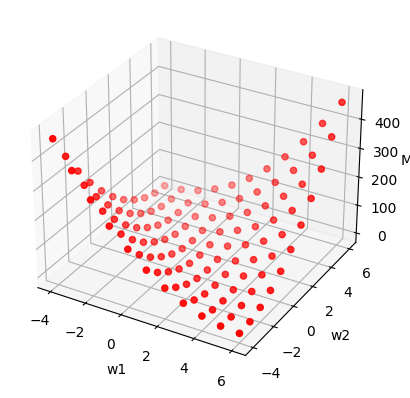

In [69]:
points = []

for w1 in np.arange(-4, 7, 1):
    for w2 in np.arange(-4, 7, 1):
        w = [w1, w2]
        y_pred = X @ w
        mse = int(mean_squared_error(y, y_pred))
        points.append((w1, w2, mse))

w1_vals = [point[0] for point in points]
w2_vals = [point[1] for point in points]
mse_vals = [point[2] for point in points]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(w1_vals, w2_vals, mse_vals, c='r', marker='o')

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('MSE')

plt.show()

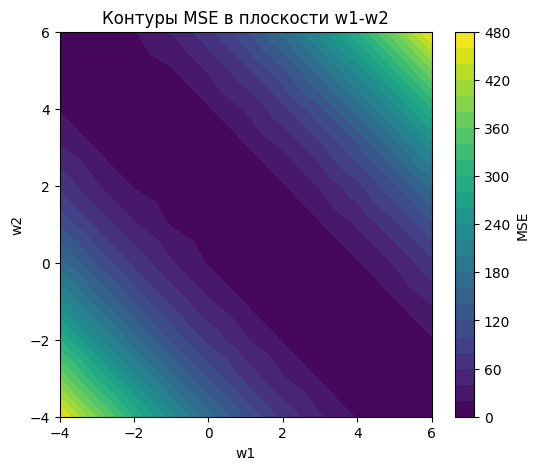

In [70]:
plt.figure(figsize=(6, 5))
contour = plt.tricontourf(w1_vals, w2_vals, mse_vals, levels=30, cmap='viridis')
plt.colorbar(contour, label='MSE')

plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Контуры MSE в плоскости w1-w2')

plt.show()